In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from src.dlm_functions import computeAnormaly,forwardFilteringM, Model,PlotEWS

import matplotlib.pyplot as plt

fill_value = -9999


In [67]:
# ## GPP time seires
# variable_list =  ['RAIN','T','VPD','RN']# ['T', 'T_NIGHT', 'T_DAY', 'SWDOWN', 'LWDOWN', 'VPD', 'RAIN', 'WIND', 'RN', 'TSOIL', 'GF', 'QLE', 'QH', 'NEE', 'RECO', 'GPP']
# GPP = pd.read_csv('../Inputs/GF-Guy_daily.csv',sep = ';')
# GPP = GPP[(GPP['DAY']!=29) | (GPP['MONTH']!=2)]

# GPP[GPP == -9999] = np.nan
# GPP_monthly = GPP.drop('DAY',axis=1).groupby([GPP['YEAR'], GPP['MONTH']]).mean()
# N = GPP_monthly['GPP'].to_numpy();N

# CLM = GPP_monthly[variable_list].to_numpy();CLM
# date0 = datetime(2004,1,1) # the data of first NDVI obervation

# # daily averages of climate conditions in the same order
# AvgCLM = GPP.drop(['YEAR'],axis=1).groupby([GPP['DAY'],GPP['MONTH']]).mean()[variable_list].to_numpy();AvgCLM

In [89]:
file = '/Users/quan/projects/gitprojects/fluxnet/Data/FLX_GF-Guy_FLUXNET2015_FULLSET_2004-2014_2-4/FLX_GF-Guy_FLUXNET2015_FULLSET_DD_2004-2014_2-4.csv'

variable_list = ['TA_F', 'VPD_F', 'P_F', 'NETRAD']
GPP = pd.read_csv(file,sep = ',')[['TIMESTAMP','GPP_DT_VUT_REF', 'RECO_DT_VUT_REF','NEE_VUT_REF','NEE_VUT_REF_QC'] + variable_list]
GPP[GPP == -9999] = np.nan
GPP['datetime'] = pd.to_datetime(GPP['TIMESTAMP'], format='%Y%m%d')
GPP = GPP[GPP['datetime']<= '2015-01-01']
GPP_monthly = GPP.groupby([GPP['datetime'].dt.year, GPP['datetime'].dt.month]).mean()
N = GPP_monthly['NEE_VUT_REF'].to_numpy();N

CLM = GPP_monthly[variable_list].to_numpy();CLM

# daily averages of climate conditions in the same order
AvgCLM = GPP.groupby([GPP['datetime'].dt.month,GPP['datetime'].dt.day]).mean()[variable_list].to_numpy();AvgCLM
date0 = GPP['datetime'][0] # the data of first NDVI obervation
GPP 
# GPP_DT_VUT_REF	TA_F	VPD_F	P_F	NETRAD	datetime
# fluxnet2015 11.27800	25.648	3.872	9.8	105.013750	2004-01-01
# icos: 11.26490	25.648	3.232	9.8	105.013750	2004-01-01

,TIMESTAMP,GPP_DT_VUT_REF,RECO_DT_VUT_REF,NEE_VUT_REF,NEE_VUT_REF_QC,TA_F,VPD_F,P_F,NETRAD,datetime
0,20040101,11.27800,14.30970,1.678830,1.000000,25.648,3.872,9.8,105.013750,2004-01-01
1,20040102,13.20640,14.41660,-1.447410,1.000000,26.410,5.431,1.0,131.993333,2004-01-02
2,20040103,10.49510,14.37760,2.035670,1.000000,26.123,4.641,6.4,78.747292,2004-01-03
3,20040104,10.32430,14.24900,1.295850,1.000000,25.195,2.748,20.4,83.329583,2004-01-04
4,20040105,11.28280,14.68690,0.854112,1.000000,24.824,2.779,33.6,105.562917,2004-01-05
...,...,...,...,...,...,...,...,...,...,...
4013,20141227,7.35821,8.48712,0.552691,1.000000,24.474,1.806,13.0,101.920625,2014-12-27
4014,20141228,8.98906,7.62361,-1.057450,1.000000,24.920,2.871,2.6,150.307708,2014-12-28
4015,20141229,8.11901,6.91368,-0.624255,1.000000,24.602,2.345,1.8,103.545000,2014-12-29
4016,20141230,8.14998,7.29943,1.253480,0.979167,25.423,3.900,13.6,108.117500,2014-12-30


In [90]:
# compute climate anomaly within each interval of two NDVI observations
anCLM = computeAnormaly(CLM,AvgCLM,date0) # 计算气象因素的异常值,16天的数据与对应期间年平均数据的差值

In [91]:
Y = N[1:]-np.nanmean(N) # 不理解为什么不是从N[0:]开始, 好像是要用当期的环境因素预测下一期的NDVI
# use two seasonal harmonic components # 使用两个季节性谐波分量
rseas = [1,2] 

# include lag-1 centerred NDVI and precipitation in the regression module #只包含上起的NDVI和降水
X = np.column_stack((N[:-1]-np.nanmean(N),anCLM[:-1,0]))

# set up model and run forward filtering
delta = 0.98

In [92]:
M = Model(Y,X,rseas,delta) # 构建模型
FF = forwardFilteringM(M,period=12) # 求解模型

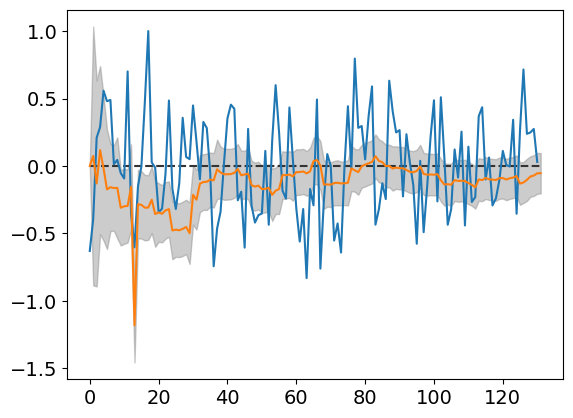

In [93]:
# scaled Y and the mean effects of autocorrelation
# extract estimates on the coefficient corresponding to lag-1 NDVI
plt.hlines(y=0, xmin=0, xmax=len(Y), color='#333333', linestyle='--')
plt.plot(Y/max(abs(Y)))
plt.plot(FF.get('sm')[2,:])

sC = np.sqrt(FF.get('sC')[2,2,:]) # std
plt.fill_between(range(len(sC)), FF.get('sm')[2,:] + sC,FF.get('sm')[2,:] - sC, color='gray', alpha=0.4, label='Confidence Interval')
# plt.ylim(-0.6, 0.6) # 设置y轴刻度范围为0到12


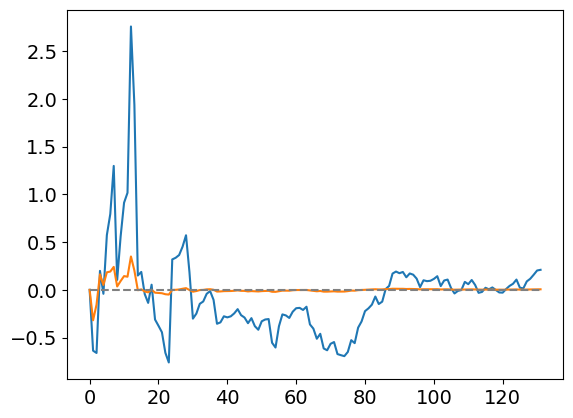

In [94]:
# local mean and local trends
plt.plot(FF.get('sm')[0,:]) # local mean
plt.plot(FF.get('sm')[1,:]) # local trend
plt.hlines(y=0, xmin=0, xmax=len(Y), color='gray', linestyle='--')

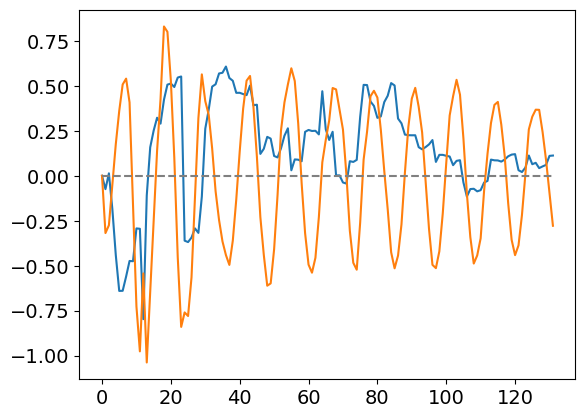

In [95]:
# climate effects and season effects
# extract estimates on the coefficient corresponding to lag-1 NDVI
plt.plot(FF.get('sm')[3,:]) # environmental effects
plt.plot(FF.get('sm')[4,:]) # local trend
plt.hlines(y=0, xmin=0, xmax=len(Y), color='gray', linestyle='--')